In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/SUPN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,7.39,7.45,7.05,7.29,7.29,150300
1,1/3/2013,7.32,7.33,7.13,7.15,7.15,231900
2,1/4/2013,7.22,7.32,7.13,7.22,7.22,115500
3,1/7/2013,7.22,7.29,7.11,7.17,7.17,46100
4,1/8/2013,7.13,7.28,7.07,7.18,7.18,49500


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 80.719992.3, cost: -32893.742188, total money: 10080.719992
epoch: 20, total rewards: 386.749989.3, cost: -33526.890625, total money: 10386.749989
epoch: 30, total rewards: 1145.579976.3, cost: -34124.851562, total money: 11078.929974
epoch: 40, total rewards: 1033.089986.3, cost: -34607.960938, total money: 11033.089986
epoch: 50, total rewards: 635.619993.3, cost: -34363.007812, total money: 10612.789993
epoch: 60, total rewards: 449.799995.3, cost: -34484.757812, total money: 10449.799995
epoch: 70, total rewards: 1036.999990.3, cost: -34551.441406, total money: 10897.889990
epoch: 80, total rewards: 1048.890001.3, cost: -34748.304688, total money: 11003.400001
epoch: 90, total rewards: 1090.720020.3, cost: -34712.718750, total money: 10906.520019
epoch: 100, total rewards: 1010.460015.3, cost: -34397.566406, total money: 10640.410016
epoch: 110, total rewards: 783.099988.3, cost: -34465.328125, total money: 10598.899987
epoch: 120, total rewards: 824.21999

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 7.290000, total balance 9992.710000
day 1: buy 1 unit at price 7.150000, total balance 9985.560000
day 2: buy 1 unit at price 7.220000, total balance 9978.340000
day 4, sell 1 unit at price 7.180000, investment -1.508918 %, total balance 9985.520000,
day 5, sell 1 unit at price 7.310000, investment 2.237760 %, total balance 9992.830000,
day 7: buy 1 unit at price 7.080000, total balance 9985.750000
day 8: buy 1 unit at price 7.160000, total balance 9978.590000
day 9, sell 1 unit at price 7.250000, investment 0.415515 %, total balance 9985.840000,
day 10, sell 1 unit at price 7.110000, investment 0.423732 %, total balance 9992.950000,
day 11: buy 1 unit at price 7.140000, total balance 9985.810000
day 15: buy 1 unit at price 7.430000, total balance 9978.380001
day 18, sell 1 unit at price 7.540000, investment 5.307264 %, total balance 9985.920001,
day 19, sell 1 unit at price 7.700000, investment 7.843137 %, total balance 9993.620000,
day 21, sell 1 unit at pr

day 298, sell 1 unit at price 8.890000, investment -3.787873 %, total balance 9948.420002,
day 301, sell 1 unit at price 10.070000, investment 3.070616 %, total balance 9958.490002,
day 302, sell 1 unit at price 9.900000, investment 7.608694 %, total balance 9968.390001,
day 303, sell 1 unit at price 10.010000, investment 11.222225 %, total balance 9978.400002,
day 304, sell 1 unit at price 9.740000, investment 5.984768 %, total balance 9988.140001,
day 305, sell 1 unit at price 9.610000, investment 5.142224 %, total balance 9997.750001,
day 306: buy 1 unit at price 9.110000, total balance 9988.640001
day 307, sell 1 unit at price 8.630000, investment -8.093719 %, total balance 9997.270001,
day 310: buy 1 unit at price 8.500000, total balance 9988.770001
day 311, sell 1 unit at price 8.550000, investment -14.840635 %, total balance 9997.320002,
day 312: buy 1 unit at price 8.940000, total balance 9988.380002
day 313, sell 1 unit at price 9.550000, investment -4.975124 %, total balance 

day 464: buy 1 unit at price 7.830000, total balance 9943.730007
day 465, sell 1 unit at price 7.860000, investment -6.539830 %, total balance 9951.590007,
day 466: buy 1 unit at price 8.020000, total balance 9943.570007
day 469, sell 1 unit at price 7.910000, investment -3.182377 %, total balance 9951.480007,
day 470: buy 1 unit at price 8.400000, total balance 9943.080007
day 471: buy 1 unit at price 8.490000, total balance 9934.590007
day 473: buy 1 unit at price 8.260000, total balance 9926.330007
day 475, sell 1 unit at price 8.790000, investment 12.836971 %, total balance 9935.120007,
day 479: buy 1 unit at price 8.900000, total balance 9926.220007
day 480: buy 1 unit at price 8.940000, total balance 9917.280008
day 481: buy 1 unit at price 8.860000, total balance 9908.420008
day 482: buy 1 unit at price 8.790000, total balance 9899.630008
day 483, sell 1 unit at price 8.950000, investment 6.674606 %, total balance 9908.580008,
day 485: buy 1 unit at price 8.900000, total balance

day 652: buy 1 unit at price 19.219999, total balance 9868.260016
day 655: buy 1 unit at price 17.840000, total balance 9850.420016
day 657: buy 1 unit at price 18.059999, total balance 9832.360016
day 658: buy 1 unit at price 17.430000, total balance 9814.930016
day 660: buy 1 unit at price 18.370001, total balance 9796.560015
day 661, sell 1 unit at price 17.450001, investment 24.642863 %, total balance 9814.010016,
day 662: buy 1 unit at price 18.410000, total balance 9795.600016
day 663: buy 1 unit at price 16.770000, total balance 9778.830016
day 664, sell 1 unit at price 16.730000, investment 14.667576 %, total balance 9795.560015,
day 665: buy 1 unit at price 15.390000, total balance 9780.170015
day 666: buy 1 unit at price 15.740000, total balance 9764.430015
day 667: buy 1 unit at price 16.480000, total balance 9747.950016
day 668, sell 1 unit at price 17.520000, investment 10.188685 %, total balance 9765.470016,
day 670: buy 1 unit at price 18.150000, total balance 9747.32001

day 822: buy 1 unit at price 16.719999, total balance 9684.150014
day 823, sell 1 unit at price 16.549999, investment 24.905655 %, total balance 9700.700014,
day 824: buy 1 unit at price 16.580000, total balance 9684.120014
day 826: buy 1 unit at price 16.370001, total balance 9667.750013
day 827, sell 1 unit at price 16.320000, investment 13.886949 %, total balance 9684.070013,
day 828, sell 1 unit at price 16.770000, investment 22.498181 %, total balance 9700.840013,
day 829: buy 1 unit at price 16.299999, total balance 9684.540014
day 830, sell 1 unit at price 16.580000, investment 30.551182 %, total balance 9701.120014,
day 832: buy 1 unit at price 17.809999, total balance 9683.310014
day 833: buy 1 unit at price 17.549999, total balance 9665.760015
day 835: buy 1 unit at price 17.080000, total balance 9648.680015
day 836, sell 1 unit at price 17.170000, investment 34.350551 %, total balance 9665.850015,
day 837: buy 1 unit at price 17.160000, total balance 9648.690015
day 838, sel

day 982, sell 1 unit at price 22.250000, investment -1.895945 %, total balance 9710.080007,
day 983, sell 1 unit at price 22.700001, investment 0.000000 %, total balance 9732.780008,
day 984: buy 1 unit at price 21.650000, total balance 9711.130008
day 985: buy 1 unit at price 22.250000, total balance 9688.880008
day 986, sell 1 unit at price 21.549999, investment -2.444549 %, total balance 9710.430007,
day 987, sell 1 unit at price 21.150000, investment -4.901080 %, total balance 9731.580007,
day 988: buy 1 unit at price 21.799999, total balance 9709.780008
day 989: buy 1 unit at price 22.200001, total balance 9687.580007
day 990, sell 1 unit at price 22.950001, investment 4.986277 %, total balance 9710.530008,
day 992: buy 1 unit at price 22.299999, total balance 9688.230009
day 993, sell 1 unit at price 23.000000, investment 7.728335 %, total balance 9711.230009,
day 994: buy 1 unit at price 23.200001, total balance 9688.030008
day 996, sell 1 unit at price 22.799999, investment 3.3

day 1145: buy 1 unit at price 42.299999, total balance 9551.209997
day 1147, sell 1 unit at price 43.500000, investment 59.049358 %, total balance 9594.709997,
day 1148, sell 1 unit at price 42.799999, investment 50.175436 %, total balance 9637.509996,
day 1149: buy 1 unit at price 42.200001, total balance 9595.309995
day 1151, sell 1 unit at price 41.000000, investment 44.112474 %, total balance 9636.309995,
day 1154, sell 1 unit at price 40.599998, investment 42.706493 %, total balance 9676.909994,
day 1155, sell 1 unit at price 41.700001, investment 46.830991 %, total balance 9718.609994,
day 1156, sell 1 unit at price 41.049999, investment 33.279222 %, total balance 9759.659994,
day 1157: buy 1 unit at price 42.099998, total balance 9717.559995
day 1158: buy 1 unit at price 41.700001, total balance 9675.859994
day 1159: buy 1 unit at price 41.200001, total balance 9634.659994
day 1160, sell 1 unit at price 40.349998, investment 29.119995 %, total balance 9675.009992,
day 1162, sell

day 1324: buy 1 unit at price 44.099998, total balance 9496.529996
day 1325, sell 1 unit at price 45.349998, investment 19.973543 %, total balance 9541.879995,
day 1326, sell 1 unit at price 45.799999, investment 20.844320 %, total balance 9587.679994,
day 1327, sell 1 unit at price 45.650002, investment 16.901415 %, total balance 9633.329996,
day 1328: buy 1 unit at price 46.049999, total balance 9587.279996
day 1329: buy 1 unit at price 45.250000, total balance 9542.029996
day 1330: buy 1 unit at price 45.299999, total balance 9496.729997
day 1331, sell 1 unit at price 46.349998, investment 17.341768 %, total balance 9543.079996,
day 1332: buy 1 unit at price 48.049999, total balance 9495.029996
day 1333: buy 1 unit at price 48.849998, total balance 9446.179998
day 1334, sell 1 unit at price 48.500000, investment 24.678658 %, total balance 9494.679998,
day 1335, sell 1 unit at price 47.500000, investment 25.661378 %, total balance 9542.179998,
day 1339, sell 1 unit at price 47.700001

day 1518, sell 1 unit at price 36.910000, investment -24.442168 %, total balance 9839.949998,
day 1519: buy 1 unit at price 37.830002, total balance 9802.119997
day 1520, sell 1 unit at price 37.419998, investment -18.652178 %, total balance 9839.539995,
day 1521: buy 1 unit at price 37.160000, total balance 9802.379995
day 1522: buy 1 unit at price 38.049999, total balance 9764.329996
day 1523: buy 1 unit at price 37.619999, total balance 9726.709997
day 1526, sell 1 unit at price 36.340000, investment -27.825221 %, total balance 9763.049997,
day 1527: buy 1 unit at price 36.150002, total balance 9726.899995
day 1528, sell 1 unit at price 36.759998, investment -24.439882 %, total balance 9763.659994,
day 1529: buy 1 unit at price 37.099998, total balance 9726.559995
day 1530: buy 1 unit at price 38.130001, total balance 9688.429994
day 1531: buy 1 unit at price 37.689999, total balance 9650.739995
day 1534: buy 1 unit at price 38.380001, total balance 9612.359994
day 1535, sell 1 unit

day 1695: buy 1 unit at price 27.510000, total balance 9647.010000
day 1696: buy 1 unit at price 27.469999, total balance 9619.540000
day 1697: buy 1 unit at price 27.480000, total balance 9592.060001
day 1698, sell 1 unit at price 26.620001, investment -11.148192 %, total balance 9618.680002,
day 1699: buy 1 unit at price 26.650000, total balance 9592.030002
day 1701: buy 1 unit at price 26.920000, total balance 9565.110002
day 1702, sell 1 unit at price 26.760000, investment -13.398056 %, total balance 9591.870002,
day 1703, sell 1 unit at price 25.480000, investment -15.123254 %, total balance 9617.350002,
day 1704: buy 1 unit at price 25.740000, total balance 9591.610002
day 1706: buy 1 unit at price 25.860001, total balance 9565.750001
day 1708: buy 1 unit at price 26.209999, total balance 9539.540002
day 1711, sell 1 unit at price 25.670000, investment -18.404320 %, total balance 9565.210002,
day 1712, sell 1 unit at price 26.650000, investment -14.528546 %, total balance 9591.86

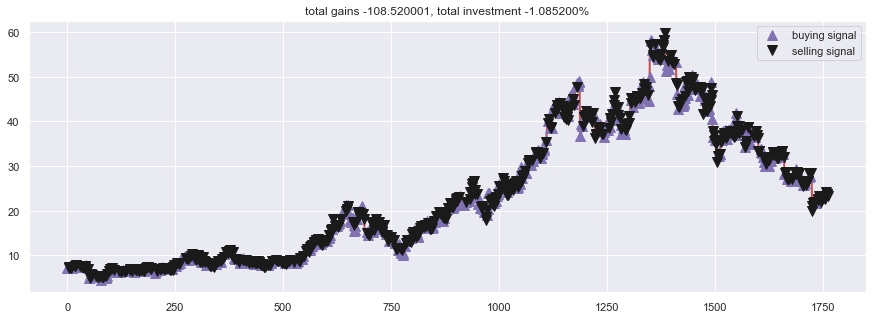

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()